In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import scipy

import mlrfit as mf
import mfmodel as mfm 

In [2]:
# np.random.seed(1001)
# random.seed(1001)

# True model is MLR factor model with SNR = 4 

Let $\Sigma = FF^T + D$ be MLR. We generate samples using 
$$
y = Fz + e, \qquad z \sim N(0, I), \qquad N(0, D).
$$

In [3]:
mtype = "small_mlr_hier"
n = 1000
signal_to_noise = 4

L = 5


ranks = np.array([10, 7, 5, 4, 1])
rank = ranks.sum()

nsamples = rank * 3
rank, nsamples

(27, 81)

In [4]:
pi_rows = np.random.permutation(n)
hpart = {'rows':{'pi':pi_rows, 'lk':[]}, 'cols':{'pi':pi_rows, 'lk':[]}} 
for ngroups in [2, 5, 9, 17, n+1]:
       hpart['rows']['lk'] += [ np.linspace(0, n, ngroups, endpoint=True, dtype=int)]
hpart['rows']['lk'][1] = np.delete(hpart['rows']['lk'][1], -2)
hpart['rows']['lk'][2] = np.delete(hpart['rows']['lk'][2], -4)
hpart['cols']['lk'] = hpart['rows']['lk']
part_sizes = mfm.print_hpart_numgroups(hpart)
mfm.valid_hpart(hpart)

level=0, num_groups=1, mean_size=1000.0
level=1, num_groups=3, mean_size=333.3
level=2, num_groups=7, mean_size=142.9
level=3, num_groups=16, mean_size=62.5
level=4, num_groups=1000, mean_size=1.0


In [5]:
hpart['rows']['lk'][:-1]

[array([   0, 1000]),
 array([   0,  250,  500, 1000]),
 array([   0,  125,  250,  375,  500,  750,  875, 1000]),
 array([   0,   62,  125,  187,  250,  312,  375,  437,  500,  562,  625,
         687,  750,  812,  875,  937, 1000])]

In [6]:
true_mlr, true_sparse_F, true_D_noise = mfm.generate_mlr_model(n, hpart, ranks, signal_to_noise, debug=True)
true_compressed_F = true_mlr.B[:, :-1]

signal_var=26.011820794779936, noise_var=6.406278374882526
SNR=4.060363798233623, signal_to_noise=4


In [7]:
true_D_noise.min(), true_D_noise.max()

(0.005126951203594061, 12.999447481114029)

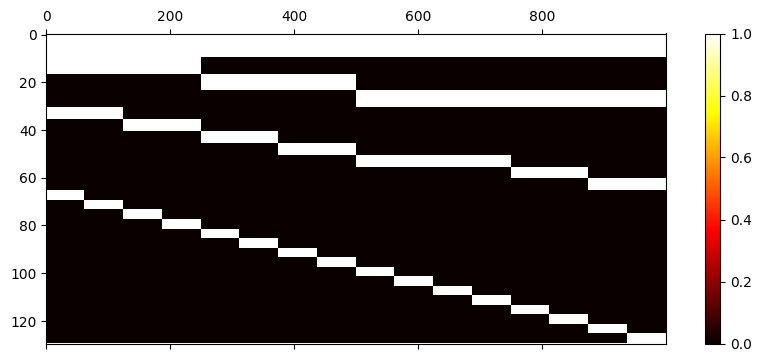

(1000, 130)


In [8]:
plt.figure(figsize=(10, 4)) 
plt.matshow(true_sparse_F.T!=0, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()
print(true_sparse_F.shape)

In [9]:
true_sparse_F.shape

(1000, 130)

In [10]:
filename = "%s_r%d_%d"%(mtype, rank, n)

In [11]:
row_selectors, si_groups, F_hpart, groups_all = mfm.row_col_selections(hpart, return_groups=True)

num_levels=5, num_sparsities=16
(16, 4) [ 0  2  6 15]


In [12]:
F_Lm1, D = true_compressed_F+0, true_D_noise+0
pi = F_hpart['pi']
F_hpart['pi_inv'] = mf.inv_permutation(pi, pi)[0]
v = np.random.randn(n)

true_mfm = mfm.MFModel(hpart=F_hpart, ranks=ranks, F=F_Lm1, D=D)
true_mfm.inv_coefficients(printing=True)

/Users/parshakova.tanya/opt/anaconda3/envs/multilevel/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [13]:
true_mlr.construct_sparse_format()
hat_x = mfm.iterative_refinement_linsolve(ranks, v[:, np.newaxis], F_Lm1, D, F_hpart, eps=1e-12, max_iter=50)
np.linalg.norm(hat_x - np.linalg.inv(true_mlr.matrix()) @ v[:, np.newaxis])

6.305572379831703e-13

In [14]:
mfm_Sigma = mfm.MFModel(F=F_Lm1, D=D, hpart=F_hpart, ranks=ranks)
mfm_Sigma.inv_coefficients(det=True)

assert true_sparse_F.shape[1] == mfm_Sigma.num_factors()

# Linear system solve, matvec

In [15]:
for _ in range(50):
    v = np.random.randn(n, 1)
    # linear system solve
    hat_x = mfm_Sigma.solve(v, eps=1e-12, max_iter=50)
    reldiff = np.linalg.norm(hat_x - np.linalg.solve(true_mlr.matrix(),v)) / np.linalg.norm(v)
    # print(f"solve {reldiff=}")
    assert np.allclose(reldiff, 0)

    # matvec
    Av = mfm_Sigma.matvec(v)
    reldiff = np.linalg.norm(Av - true_mlr.matvec(v)) / np.linalg.norm(v)
    assert reldiff < 1e-12, print(f"matvec {reldiff=}")


    # Fz
    z = np.random.randn(mfm_Sigma.num_factors(), 1)
    Fz = mfm_Sigma.F_matvec(z)
    reldiff = np.linalg.norm(Fz - true_sparse_F @ z) / np.linalg.norm(z)
    assert reldiff < 1e-12, print(f"matvec {reldiff=}")


print("PASSED")

PASSED


# Test $\mathop{diag}(\Sigma)$

In [16]:
d1 = np.diag(true_mlr.matrix())
d2 = mfm_Sigma.diag()
assert np.allclose(d1, d2)

print("PASSED")

PASSED


# Test $\Sigma$

In [17]:
assert np.allclose(true_mlr.matrix(), mfm_Sigma.matrix())

print("PASSED")

PASSED


In [18]:
def estimate_diagonal(n, A_matvec, num_samples=10000):
    diagonal_estimates = np.zeros((n, 1))
    qk = 0
    for _ in range(num_samples):
        zk = np.random.randn(n, 1)
        # zk = np.random.choice([-1, 1], size=n) 
        Azk = A_matvec(zk)
        diagonal_estimates += zk * Azk
        qk = qk + (zk * zk)
    # assert Azk.shape == diagonal_estimates.shape
    return diagonal_estimates / qk

# Example usage with a mock matrix-vector product function
A = np.random.randn(100, 100)
A = A @ A.T


In [19]:
for num_samples in [10, 100, 1000, 10000, 100000, 1000000]:
    estimated_diag = estimate_diagonal(100, lambda x: A @ x, num_samples=num_samples)
    print(f"{num_samples=}, rel_diff={mf.rel_diff(np.diag(A), estimated_diag.flatten()):.6f}")

num_samples=10, rel_diff=0.352082
num_samples=100, rel_diff=0.086311
num_samples=1000, rel_diff=0.034964
num_samples=10000, rel_diff=0.009967
num_samples=100000, rel_diff=0.002761
num_samples=1000000, rel_diff=0.000886


In [20]:
for num_samples in [10, 100, 1000, 10000]:
    estimated_diag = estimate_diagonal(n, lambda x: mfm_Sigma.matvec(x), num_samples=num_samples)
    print(f"{num_samples=}, rel_diff={mf.rel_diff(mfm_Sigma.diag(), estimated_diag.flatten()):.6f}")

num_samples=10, rel_diff=1.245687
num_samples=100, rel_diff=0.340371
num_samples=1000, rel_diff=0.110901
num_samples=10000, rel_diff=0.035380


# EM elements

In [21]:
num_sparsities = row_selectors.size - 1
tilde_F0 = mf.convert_compressed_to_sparse(F_Lm1, F_hpart, ranks[:-1])
D1 = np.zeros(n)
# for si in tqdm(range(num_sparsities)):
for si in range(num_sparsities):
    si_col = mfm.group_to_indices(si_groups[si], part_sizes, ranks)
    tilde_F_ci = true_sparse_F[:, si_col]
    assert np.allclose(tilde_F_ci, mfm.get_sparse_F_si_col_sparsity(F_Lm1, ranks, F_hpart, si_groups[si]))

print("PASSED")

PASSED


In [22]:
assert np.allclose(mfm.perm_hat_Sigma(F_Lm1, D, F_hpart, ranks), mfm.perm_hat_Sigma_sp(true_sparse_F, D))
print("PASSED")

PASSED


In [23]:
E = np.random.randn(n, nsamples)
E1 = np.diag(np.sqrt(true_D_noise)) @ E
E2 = np.sqrt(true_D_noise)[:, None] * E

assert np.allclose(E1, E2)

In [24]:
# C = mfm.generate_data(true_sparse_F, true_D_noise, nsamples, true_mlr)
C = mfm.sample_data(nsamples, mfm_Sigma)

Z = (C - C.mean(axis=1, keepdims=True))[F_hpart["pi"], :]
unpermuted_A = (Z @ Z.T / (Z.shape[1]-1))[mfm_Sigma.pi_inv, :][:, mfm_Sigma.pi_inv]

# permute to put clusters on diagonal
Y = Z.T
N = Y.shape[0]

# True model loglikelihoods

In [25]:
true_Sigma = mfm.perm_hat_Sigma_sp(true_sparse_F, true_D_noise)
tr_lu, tr_piv = scipy.linalg.lu_factor(true_Sigma)
true_train_obj = mfm.loglikelihood_value(true_Sigma, tr_lu, tr_piv, Y)
exp_true_ll = mfm.exp_true_loglikelihood_value(true_Sigma)
print(f"TR: train ll={true_train_obj}, exp ll={exp_true_ll}")

TR: train ll=-2425.9499735742647, exp ll=-2433.0883638067908


In [26]:
permuted_F_hpart = {"pi_inv":np.arange(n), "pi":np.arange(n), "lk":F_hpart["lk"]}

In [27]:
row_selectors_L, si_groups_L, groups_all_L = mfm.si_row_col(hpart["rows"])
exp_true_ll = mfm.fast_exp_true_loglikelihood_value(mfm_Sigma)
exp_true_ll2 = mfm.exp_true_loglikelihood_value(mfm_Sigma.matrix())
exp_true_ll3 = mfm.fast_exp_loglikelihood_value(np.concatenate([true_mfm.F, np.sqrt(true_mfm.D).reshape(-1, 1)], axis=1), 
                                                        mfm_Sigma, ranks, hpart["rows"], 
                                                        row_selectors, si_groups)
assert np.allclose(exp_true_ll, exp_true_ll2)
assert np.allclose(exp_true_ll, exp_true_ll3)
print(f"{exp_true_ll=}")

exp_true_ll=-2433.0883679077724


In [28]:
mfm.exp_loglikelihood_value(true_Sigma, true_Sigma, tr_lu, tr_piv)

-2433.0883638067908

In [29]:
np.linalg.det(mfm_Sigma.matrix()), mfm_Sigma.D.min(), mfm_Sigma.D.max()

/Users/parshakova.tanya/opt/anaconda3/envs/multilevel/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


(inf, 0.005126951203594061, 12.999447481114029)

In [30]:
np.linalg.det(true_Sigma), np.linalg.slogdet(true_Sigma)

(inf, SlogdetResult(sign=1.0, logabsdet=2028.2996612042357))

In [31]:
true_train_obj = mfm.fast_loglikelihood_value(mfm_Sigma, Y[:, mfm_Sigma.pi_inv])
true_ll = {"train":true_train_obj, "exp":exp_true_ll}
print(f"True: {true_ll}")

True: {'train': -2425.949977675248, 'exp': -2433.0883679077724}


In [32]:
mfm_Sigma.init_FD(ranks, F_hpart, init_type="Y", Y=Y)
F0, D0 = mfm_Sigma.F, mfm_Sigma.D

# Test $\log \det \Sigma$

In [33]:
for t in range(10):
    if t == 0:
        mfm_Sigma.init_FD(ranks, F_hpart, init_type="Y", Y=Y)
        F0, D0 = mfm_Sigma.F, mfm_Sigma.D
    else:
        F0, D0 = np.random.randn(mfm_Sigma.F.shape[0], mfm_Sigma.F.shape[1]), np.random.rand(n) + 1e-2
    Sigma = mfm.perm_hat_Sigma(F0, D0, F_hpart, ranks)
    (sign, logabsdet) = np.linalg.slogdet(Sigma)
    assert sign == 1, print(sign, logabsdet, np.linalg.det(Sigma))

    num_factors = mfm_Sigma.num_factors()
    rescaled_sparse_F = mf.convert_compressed_to_sparse(np.power(D0, -0.5)[:, np.newaxis] * F0, 
                                                F_hpart, 
                                                ranks[:-1])
    sigmas = scipy.sparse.linalg.svds( rescaled_sparse_F, k=num_factors-1, return_singular_vectors=False, which='LM')
    last_sigma = scipy.sparse.linalg.svds(rescaled_sparse_F, k=1, return_singular_vectors=False, which='SM')

    logdet = np.log(D0).sum() + np.log(sigmas**2 + 1).sum() + np.log(last_sigma**2 + 1).sum()

    assert np.allclose(logdet, logabsdet)

print("PASSED")

PASSED


In [34]:
np.diag(unpermuted_A).min(), np.diag(unpermuted_A).max(), true_D_noise.min(), true_D_noise.max()

(7.20165039788422, 73.36930642691019, 0.005126951203594061, 12.999447481114029)

In [35]:
np.allclose(true_mfm.matrix()[true_mfm.pi, :][:, true_mfm.pi], true_Sigma)

True

In [36]:
loglikelihoods = [-np.inf]
N = Y.shape[0]
eps = 1e-12

fitted_mfm = mfm.MFModel(hpart=F_hpart, ranks=ranks, F=F0, D=D0)
fitted_mfm.inv_coefficients(det=True)
for t in range(50):
    obj1 = mfm.fast_loglikelihood_value(fitted_mfm, Y[:, fitted_mfm.pi_inv])

    Sigma0 = mfm.perm_hat_Sigma(F0, D0, permuted_F_hpart, ranks)
    lu, piv = scipy.linalg.lu_factor(Sigma0)
    obj2 = mfm.loglikelihood_value(Sigma0, lu, piv, Y)
    assert np.allclose(obj1, obj2), print(obj1, obj2)
    
    loglikelihoods += [obj1]

    F1 = mfm.fast_EM_get_F(F0, D0, Y, ranks, permuted_F_hpart, row_selectors, si_groups)
    F1_slow = mfm.EM_get_F(F0, lu, piv, Y, ranks, part_sizes, permuted_F_hpart, row_selectors, si_groups)
    assert mf.rel_diff(F1, F1_slow) < 1e-8, print(mf.rel_diff(F1, F1_slow))
    D1 = mfm.fast_EM_get_D(F0, D0, F1, Y, ranks, permuted_F_hpart, row_selectors, si_groups)
    D1_slow = mfm.EM_get_D(F0, F1, lu, piv, Y, ranks, part_sizes, permuted_F_hpart, row_selectors, si_groups)
    assert mf.rel_diff(D1, D1_slow) < 1e-8, print(mf.rel_diff(D1, D1_slow))
    F0, D0 = F1, D1
    assert D1.min() >= -1e-8 and loglikelihoods[-2] - 1e-8 <= loglikelihoods[-1]
    fitted_mfm = mfm.MFModel(hpart=F_hpart, ranks=ranks, F=F1, D=D1)
    fitted_mfm.inv_coefficients(printing=True, det=True)
    if t % 10 == 0:
        print(f"{t=}, {obj1=}, {D1.min()=}, {D1.max()=}, {mf.rel_diff(F1, F1_slow)}, {mf.rel_diff(D1, D1_slow)}")
    
        row_selectors_L, si_groups_L, groups_all_L = mfm.si_row_col(hpart["rows"])
        exp_true_ll = mfm.fast_exp_loglikelihood_value(np.concatenate([true_mfm.F, np.sqrt(true_mfm.D).reshape(-1, 1)], axis=1), 
                                                        fitted_mfm, ranks, hpart["rows"], 
                                                        row_selectors, si_groups)
        Sigma_fitted = fitted_mfm.matrix()
        fit_lu, fit_piv = scipy.linalg.lu_factor(Sigma_fitted)
        exp_true_ll2 = mfm.exp_loglikelihood_value(true_mfm.matrix(), Sigma_fitted, fit_lu, fit_piv)
        assert np.allclose(exp_true_ll, exp_true_ll2), print(exp_true_ll, exp_true_ll2)

    if loglikelihoods[-1] - loglikelihoods[-2] < eps * abs(loglikelihoods[-2]):
        print(f"terminating at {t=}")
        break

print(f"{t=}, {obj1=}")

print("PASSED")

t=0, obj1=-48219.36820865318, D1.min()=0.11626722173724811, D1.max()=33.5054244804008, 1.8475168871873095e-10, 2.4635258375202632e-11
t=10, obj1=-2386.832988097401, D1.min()=0.13467836651676562, D1.max()=16.089375091810197, 8.804609101543522e-11, 6.642580505845707e-11
t=20, obj1=-2332.1259193731207, D1.min()=0.056667398679235106, D1.max()=15.521599116888474, 2.4337302653824284e-10, 1.9505639043313477e-10
t=30, obj1=-2310.487651608291, D1.min()=0.03180429707462713, D1.max()=14.469557864819397, 2.9807490631844495e-10, 3.0145586610437897e-10
t=40, obj1=-2300.7619567636702, D1.min()=0.025807785815916837, D1.max()=13.971095016450718, 1.7778628219467972e-10, 1.4994512903739036e-10
t=49, obj1=-2294.0506662023363
PASSED


In [37]:
B_true = np.concatenate([true_mfm.F, np.sqrt(true_mfm.D).reshape(-1, 1)], axis=1)

In [38]:
B_prod, C_prod, ranks_prod = mfm.mlr_mlr_matmul(fitted_mfm.inv_B, fitted_mfm.inv_C, fitted_mfm.inv_ranks, 
                                                B_true, B_true, ranks, fitted_mfm.inv_hpart)
mlr1 = mf.MLRMatrix(B=B_prod, C=C_prod, hpart=hpart, ranks=ranks_prod)

In [39]:
np.allclose(mlr1.matrix(), fitted_mfm.inv() @ true_mfm.matrix())

True

In [40]:
tr_fitted_Sigma_inv_true_Sigma = mfm.full_mlr_frob_norm(B_prod, C_prod, ranks_prod, hpart["rows"], si_groups_L)**2
print(tr_fitted_Sigma_inv_true_Sigma, np.linalg.norm(mlr1.matrix(), 'fro')**2, np.trace(mlr1.matrix()))

255737.60312980748 255737.60312980702 2321.7361889930326


In [41]:
np.allclose(fitted_mfm.matrix() @ fitted_mfm.inv(), np.eye(n))

True

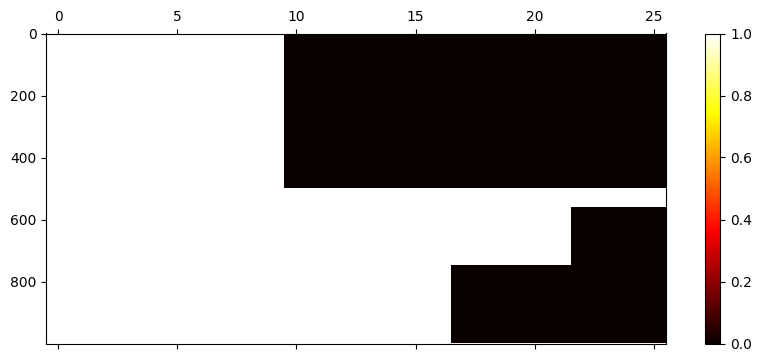

In [42]:
tilde_F_ci = mfm.get_sparse_F_si_col_sparsity(F_Lm1, ranks, F_hpart, si_groups[8])
plt.figure(figsize=(10, 4)) 
plt.matshow(tilde_F_ci!=0, aspect='auto', fignum=1, cmap='hot') 
plt.colorbar() 
plt.show()

In [43]:
import numba as nb

In [44]:
nb.njit(parallel=True)
def nb_get_sparse_F_si_col_sparsity(F_compressed, ranks, F_hpart, group):
    res = np.zeros(F_compressed.shape)
    for level in nb.prange(len(group)):
        gi = group[level]
        r1, r2 = F_hpart["lk"][level][gi], F_hpart["lk"][level][gi+1]
        res[r1:r2, ranks[:level].sum() : ranks[:level+1].sum()] = F_compressed[r1:r2, ranks[:level].sum() : ranks[:level+1].sum()]
    return res


In [45]:
%timeit nb_get_sparse_F_si_col_sparsity(F_Lm1, ranks, F_hpart, si_groups[si])

45.6 μs ± 398 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [46]:
%timeit mfm.get_sparse_F_si_col_sparsity(F_Lm1, ranks, F_hpart, si_groups[si])

44.6 μs ± 1 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [47]:
for _ in range(10):
    B1, C1 = np.random.randn(n, ranks.sum()), np.random.randn(n, ranks.sum())

    mlr1 = mf.MLRMatrix(B=B1, C=C1, hpart=hpart, ranks=ranks)

    row_selectors_L, si_groups_L, groups_all_L = mfm.si_row_col(hpart["rows"])
    
    frob_norm = mfm.full_mlr_frob_norm(B1, C1, ranks, hpart["rows"], si_groups_L)
    frob_norm2 = np.linalg.norm(mlr1.matrix(), 'fro')

    assert np.allclose(frob_norm2, frob_norm)

    tr_val = mfm.full_mlr_trace(B1, C1, ranks, hpart["rows"], row_selectors, si_groups)
    assert np.allclose(tr_val, np.trace(mlr1.matrix()))

print("PASSED")

PASSED
